In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from environment import root_dir

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [3]:
experiment_configs = {
    "game24": {
        "model": "Qwen3-1.7B",
        "folder": "tree_vis_google/gemini-2.5-pro-preview-03-25",
        "checkpoints": [5, 10, 15, 20],
        "color": colors[0],
        "marker": markers[0],
        "linestyle": '-',
    },
    "math500": {
        "model": "Qwen3-8B",
        "folder": "tree_vis_v3",
        "checkpoints": [20, 40, 60, 80],
        "color": colors[1],
        "marker": markers[1],
        "linestyle": '--',
    }
}

metrics = {
    "corrs": "Pass@1",
    "filtered_ajd": "Jump Distance",
    "average_solution_count": "Solution Count",
    "success_rates": "Success Rate",
    "average_verification_rates": "Verification Rate",
    "overthinking_rates": "Overthinking Rate",
    "forgetting_rates": "Forget Rate",
}

In [5]:
result_df = {}
stderr_df = {}

for config in experiment_configs:
    result_df[config] = {}
    stderr_df[config] = {}
    for checkpoint in experiment_configs[config]['checkpoints']:
        result_df[config][checkpoint] = {}
        stderr_df[config][checkpoint] = {}
        result_path = f"/home/zengyuchen/ReJump/results/{experiment_configs[config]['model']}-checkpoint-{checkpoint}/{config}_0_shot_1_query_qwen-instruct_reslen_404_nsamples_100_noise_None_flip_rate_0.0_mode_default/temperature_1.00/replicate_0/global_step_0/{experiment_configs[config]['folder']}/metric_df.csv"
        df = pd.read_csv(result_path)

        for metric in metrics:
            result_df[config][checkpoint][metric] = df[metric].mean()
            stderr_df[config][checkpoint][metric] = df[metric].std() / np.sqrt(len(df))


    result_df[config] = pd.DataFrame(result_df[config]).T
    stderr_df[config] = pd.DataFrame(stderr_df[config]).T
    

In [5]:
normalization_df = {}
for config in experiment_configs:
    normalization_df[config] = {}
    for metric in metrics:
        normalization_df[config][metric] = {}
        normalization_df[config][metric]['max'] = result_df[config][metric].max()
        normalization_df[config][metric]['min'] = result_df[config][metric].min()
    
for metric in metrics:
    result_df["game24"][metric] = (result_df["game24"][metric] - normalization_df["game24"][metric]['min'])/(normalization_df["game24"][metric]['max'] - normalization_df["game24"][metric]['min']) * (normalization_df["math500"][metric]['max'] - normalization_df["math500"][metric]['min']) + normalization_df["math500"][metric]['min']
    result_df["math500"][metric] = (result_df["math500"][metric] - normalization_df["math500"][metric]['min'])/(normalization_df["math500"][metric]['max'] - normalization_df["math500"][metric]['min']) * (normalization_df["game24"][metric]['max'] - normalization_df["game24"][metric]['min']) + normalization_df["game24"][metric]['min']

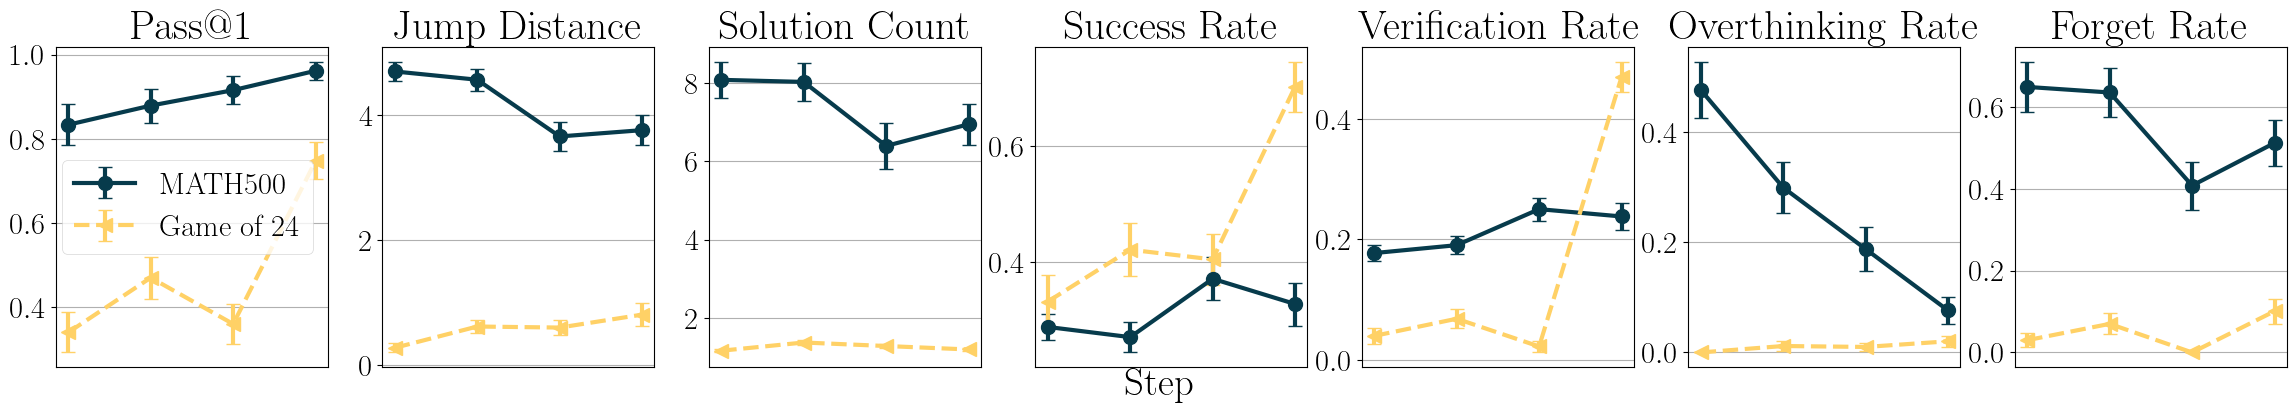

In [6]:
fig, axes = plt.subplots(1, 7, figsize=(23, 4))
fig.subplots_adjust(left=0.02, right=0.99, top=0.9, bottom=0.1, wspace=0.2)

configs_to_plot = ["game24", "math500"]
plot_labels = {"game24": "MATH500", "math500": "Game of 24"}
plot_colors = {"game24": "tab:blue", "math500": "tab:orange"}

for i, metric in enumerate([
    "corrs",
    "filtered_ajd",
    "average_solution_count",
    "success_rates",
    "average_verification_rates",
    "overthinking_rates",
    "forgetting_rates",
]):
    ax = axes[i]
    for cfg in configs_to_plot:
        checkpoints = experiment_configs[cfg]['checkpoints']
        y = [result_df[cfg][metric][checkpoint] for checkpoint in checkpoints]
        err = [stderr_df[cfg][metric][checkpoint] for checkpoint in checkpoints]
        if cfg == "math500":
            y = y[::-1]
            err = err[::-1]
        ax.errorbar(
            [1, 2, 3, 4], y, yerr=err,
            marker=experiment_configs[cfg]['marker'],
            label=plot_labels.get(cfg, cfg),
            color=experiment_configs[cfg]['color'],
            markersize=10,
            linewidth=3,
            linestyle=experiment_configs[cfg]['linestyle'],
            capsize=5
        )
    ax.set_title(metrics[metric], fontsize=30)
    # ax.set_ylabel(metrics[metric], fontsize=22)
    ax.grid(True)
    ax.set_xticks([])  # Remove xticks
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)

fig.supxlabel('Step', fontsize=28)
axes[0].legend(fontsize=22)

fig.savefig(f'{root_dir}/figures/dynamics.pdf')


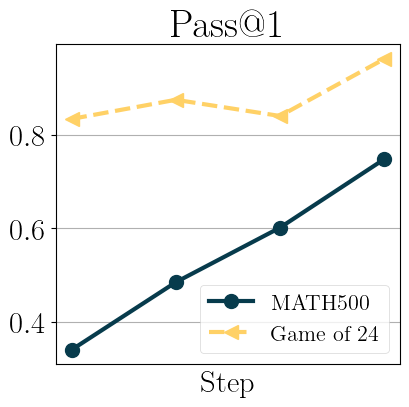

In [7]:
# Plot only pass@1 in a separate figure
fig_pass1, ax_pass1 = plt.subplots(1, 1, figsize=(4, 4))
fig_pass1.subplots_adjust(left=0.13, right=0.99, top=0.9, bottom=0.1, wspace=0.2)
configs_to_plot = ["game24", "math500"]
plot_labels = {"game24": "MATH500", "math500": "Game of 24"}

metric_pass1 = 'corrs'
for cfg in configs_to_plot:
    checkpoints = experiment_configs[cfg]['checkpoints']
    y = [result_df[cfg][metric_pass1][checkpoint] for checkpoint in checkpoints]
    if cfg == "math500":
        y = y[::-1]
    ax_pass1.plot(
        [1,2,3,4], y,
        marker=experiment_configs[cfg]['marker'],
        label=plot_labels.get(cfg, cfg),
        color=experiment_configs[cfg]['color'],
        markersize=10,
        linewidth=3,
        linestyle=experiment_configs[cfg]['linestyle']
    )
ax_pass1.set_title(metrics[metric_pass1], fontsize=28)
ax_pass1.set_xlabel('Step', fontsize=22)
ax_pass1.grid(True)
ax_pass1.set_xticks([])
ax_pass1.legend(fontsize=16)
fig_pass1.savefig(f'{root_dir}/figures/dynamics_pass1.pdf')
